# Time Series Analysis (SARIMA) on U.S. Food borne Illnesses

The following is a predictive analysis on food borne illness data from the Center for Disease Control and Prevention. The goal of the analysis is to see if an accurate and reliable forecast  can be created using the Seasonal Autoregressive Integrated Moving Average (SARIMA) model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/dchoe/Desktop/food_borne_illness/NationalOutbreakPublicDataTool.csv')

In [3]:
df.head()

,Year,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,...,Deaths,Info on Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type,Animal Type Specify,Water Status
0,2009,1,Minnesota,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,2,0.0,...,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,1,Minnesota,Food,Norovirus,NaN,Confirmed,NaN,16,0.0,...,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,1,Minnesota,Food,Norovirus,NaN,Suspected,Restaurant - Sit-down dining,5,0.0,...,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,1,Minnesota,Food,Norovirus,NaN,Confirmed,"Restaurant - ""Fast-food""(drive up service or p...",3,0.0,...,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,1,Minnesota,Food,Norovirus,NaN,Confirmed,Restaurant - other or unknown type,21,0.0,...,0.0,21.0,cookies,NaN,Multiple,NaN,NaN,NaN,NaN,NaN


### Analysis dataset 
The dataset retrieved from the CDC website (https://data.world/cdc/foodborne-outbreak-database) provided food borne illnesses data by year, month, and state. The dataset also provided in-depth information such as the etiology of the illness, hospilization/death numbers, and types of exposure data. 

For this analysis we will only use a data column and the 'Illnesses' column. The date for the data set is saved in two columns 'Year' and 'Month' and will be concatenated into `datetime` format.  

In [4]:
df = df[['Year', 'Month', 'Illnesses']] 

In [5]:
#concat 'Year' and 'Date' into datetime format
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'].astype(str), format="%Y%m")

In [6]:
df = df[['Date', 'Illnesses']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10225 entries, 0 to 10224
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10225 non-null  datetime64[ns]
 1   Illnesses  10225 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 159.9 KB


In [8]:
#grouping dataset by date and summing illnesses (monthly sum)
df = df.groupby(['Date'])['Illnesses'].sum().reset_index()

In [9]:
#setting the 'Date' as index
df.set_index(['Date'], inplace=True)

In [10]:
df.head()

,Illnesses
Date,
2009-01-01,1417
2009-02-01,1369
2009-03-01,1325
2009-04-01,1069
2009-05-01,1249


In [11]:
df = df.tail(50)

### EDA
Visual analysis for the data shows a downward trend in food borne illnesses and there are signs of seasonality. The data does not seem to be stationary. The data also seems to be irregular and may not be able to be used for predictive analysis using SARIMA. An ADFuller test will not be conducted as the `auto_arima` will determine the best p,d,q and P,D,Q for the model.  

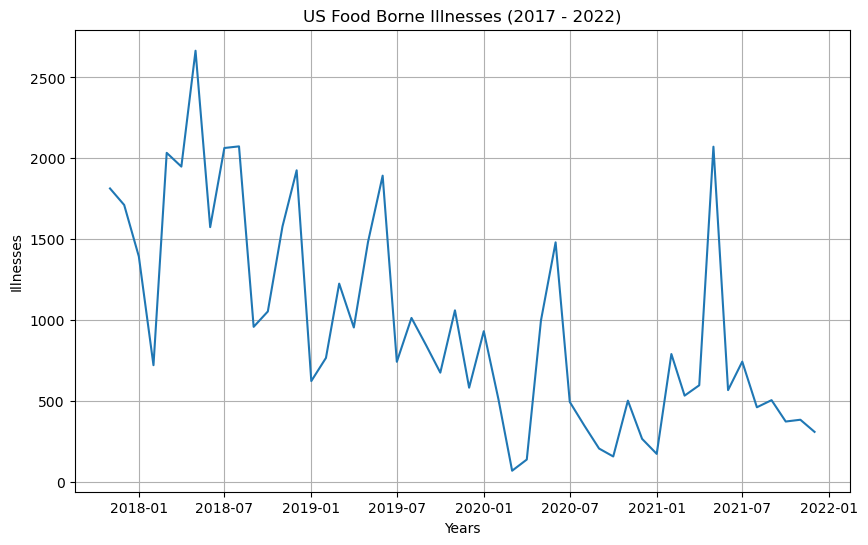

In [12]:
#graphing the food borne illnesses
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Illnesses'])
plt.title('US Food Borne Illnesses (2017 - 2022)')
plt.xlabel('Years')
plt.ylabel('Illnesses')

plt.grid()
plt.show()

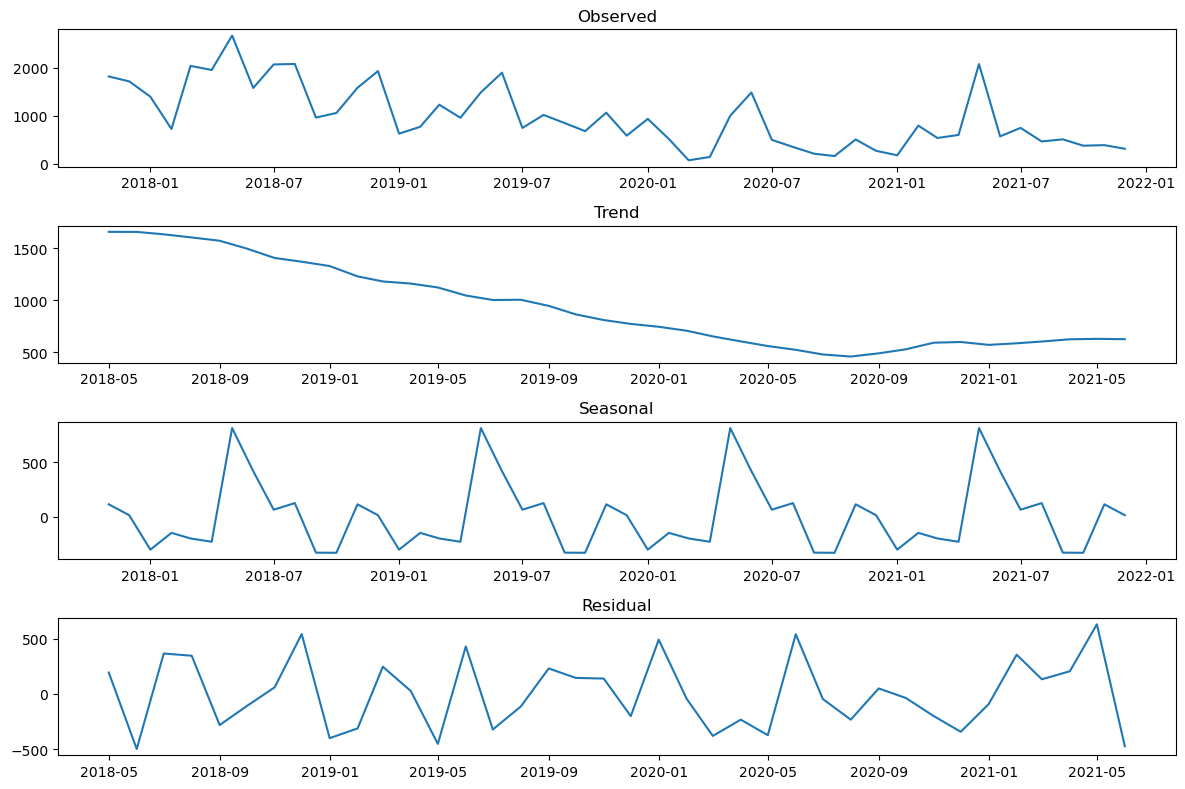

In [13]:
#creating seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Illnesses'], model='additive', period=(12))

plt.figure(figsize=(12,8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

### Modeling 
For this time series `auto_arima` was used. The model was given a d value of 1 and a D value of 1. This was done because the model was not adding a differenced value. It is possible that the `auto_arima` stationality test did not detect non-stationality for the data. Several models were ran with d and D values at 0 and the 1 value was determined to be the best. The final SARIMA model is (3,1,0)(2,1,0)[12]. 

In [14]:
import pmdarima as pm

#perform auto_arima to identify best parameters
auto_model = pm.auto_arima(df['Illnesses'], 
                           stationary=False, d=1, #added d value because the model needs to be differenced
                           seasonal=True, D=1, #added D value to match d
                           m=12, 
                           trace=True, 
                           stepwise=True,
                          error_action='ignore',
                          suppress_waring=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=596.938, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=586.713, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=586.878, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=583.058, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=589.945, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=577.925, Time=0.20 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=582.451, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=570.440, Time=0.36 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=579.487, Time=

In [15]:
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   50
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -279.220
Date:                            Sun, 20 Aug 2023   AIC                            570.440
Time:                                    10:22:53   BIC                            580.106
Sample:                                11-01-2017   HQIC                           573.848
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9110      0.211     -4.312      0.000      -1.325      -0.497
ar.L2         -0.8943      0.218   

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [17]:
train.shape, test.shape

((40, 1), (10, 1))

In [18]:
auto_model.fit(train['Illnesses'])

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
forecast = auto_model.predict(len(test.index), return_conf_int=True)

In [20]:
forecast_df = pd.DataFrame(forecast[0], index=test.index, columns=['Prediction'])
#forecast_df

### Model testing
The graph of the fitted model forecast compared to the test data shows that the model is underforecasting. 

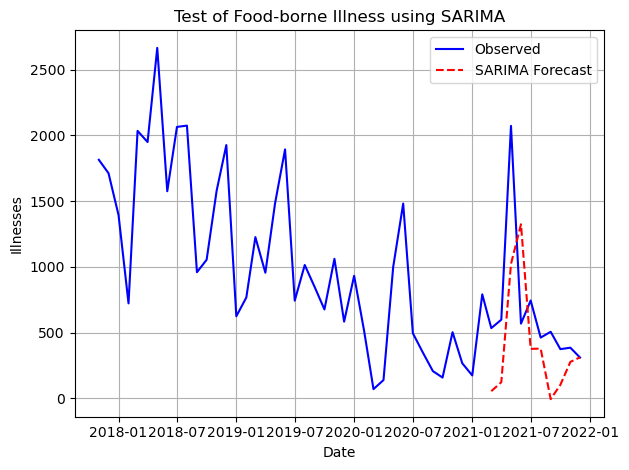

In [21]:
# Original data
plt.plot(df.index, df['Illnesses'], label='Observed', color='blue')

# SARIMA forecast
plt.plot(forecast_df.index, forecast_df['Prediction'], label='SARIMA Forecast', color='red', linestyle='--')

plt.title('Test of Food-borne Illness using SARIMA')
plt.xlabel('Date')
plt.ylabel('Illnesses')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
future_forecast = auto_model.predict(24, return_conf_int=True)
#future_forecast

In [24]:
forecast_range = pd.date_range(start='2021-01-01', periods=24, freq='MS')

In [25]:
future_forecast_df = pd.DataFrame(future_forecast[0], index=forecast_range, columns=['Prediction'])
#future_forecast_df

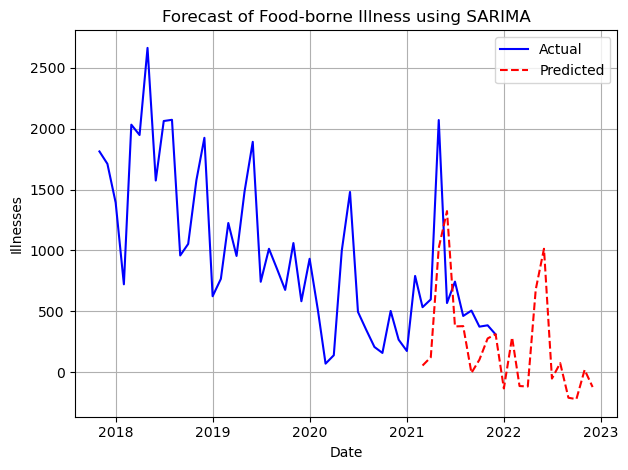

In [26]:
# Original data
plt.plot(df.index, df['Illnesses'], label='Actual', color='blue')

# SARIMA forecast
plt.plot(future_forecast_df.index, future_forecast_df['Prediction'], label='Predicted', color='red', linestyle='--')

plt.title('Forecast of Food-borne Illness using SARIMA')
plt.xlabel('Date')
plt.ylabel('Illnesses')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
#confidence interval
lower = pd.Series(future_forecast[1][:,0], index=forecast_range)
upper = pd.Series(future_forecast[1][:,1], index=forecast_range)

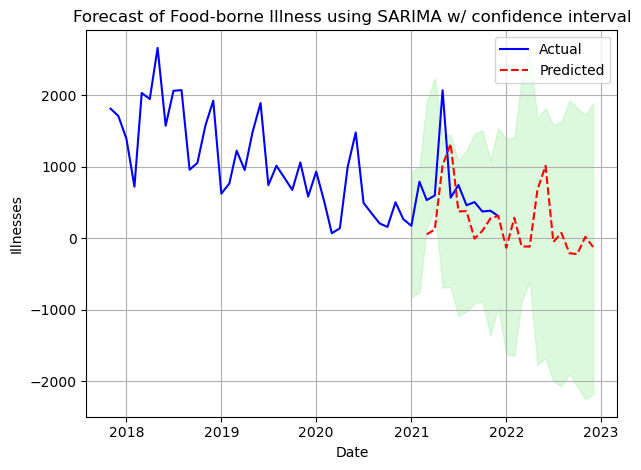

In [28]:
# Original data
plt.plot(df.index, df['Illnesses'], label='Actual', color='blue')

# SARIMA forecast
plt.plot(future_forecast_df.index, future_forecast_df['Prediction'], label='Predicted', color='red', linestyle='--')

# Confidence intervals
plt.fill_between(forecast_range, lower, upper, color='lightgreen', alpha=0.3)


plt.title('Forecast of Food-borne Illness using SARIMA w/ confidence interval')
plt.xlabel('Date')
plt.ylabel('Illnesses')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

### Accuracy
To determine the accuracy of the model the Mean Absolute Percentage Error (MAPE) was calculated betwen the prediction and the actual. The MAPE value for the model is 62.3%, indicating that the model is not a good model. 

In [22]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate MAPE for the SARIMA forecast
mape = mean_absolute_percentage_error(test['Illnesses'], forecast_df['Prediction'])

mape

0.623084315069504

### Conclusion
The model did not meet the <5% threshold to be considered an accurate and reliable model and should not be used for predicting/forecasting future food borne illnesses in the US. As indicated in the EDA, the data does seem to have an irregular trend which could be making forecasting difficult for the SARIMA model. 

### Recommendation
It is recommended that other types of of time series analysis, such as Long Short Term Memory or Prophet, be conducted to see if better results can be accomplished. 